In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import scanpy as sc
import h5py

import sys

print(f'PID number is {os.getpid()}')

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

PID number is 6720


# plotting parameters

In [2]:
mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=1.)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=1.)

mpl.rcParams['pdf.fonttype'] = 42

In [3]:
figure_folder = r'figures'

# Load adata

In [4]:
adata = sc.read_h5ad(r"MeCP2_clustered_adata_labeled.h5ad")

In [5]:
uid_to_subclass = {uid:subcls for (uid, subcls) in zip(adata.obs.index.values, adata.obs['subclass'].values)}
uid_to_exp = {uid:exp for (uid, exp) in zip(adata.obs.index.values, adata.obs['experiment'].values)}

# Load MeCP2 results

In [6]:
mecp2_folder = r'output_folder'

df_list = []
for fl in os.listdir(mecp2_folder):
    df_list.append(pd.read_csv(os.path.join(mecp2_folder,fl), index_col=0))

df_cell_with_MeCP2 = pd.concat(df_list, ignore_index=True)

df_cell_with_MeCP2['subclass'] = df_cell_with_MeCP2['uid'].apply(lambda x: uid_to_subclass[x])
df_cell_with_MeCP2['experiment'] = df_cell_with_MeCP2['uid'].apply(lambda x: uid_to_exp[x])

subcls_exp_mean = {}
for (subcls, exp), df in df_cell_with_MeCP2.groupby(['subclass', 'experiment']):
    subcls_exp_mean[(subcls, exp)] = np.log10(np.mean(df['MeCP2_mean']))
df_cell_with_MeCP2['norm_MeCP2_mean'] = df_cell_with_MeCP2.apply(lambda x:np.log10(x['MeCP2_mean'])/subcls_exp_mean[(x['subclass'],
                                                                                                                 x['experiment'])],
                                                                        axis = 1)

df_cell_with_MeCP2.head()

,uid,fov,cellID,DAPI_mean,MeCP2_mean,MeCP2_internal_variation,local_MeCP2_signal,subclass,experiment,norm_MeCP2_mean
0,100488189023469889594930787401453076425,0,84,13327.583485,15890.948905,0.052007,1.645142,Oligo,0722,1.162929
1,112375315532908816646758313607652797643,0,76,9807.039362,2327.309309,0.141345,1.189077,OPC,0722,0.938860
2,114854375025109577381176113053841629115,0,37,10288.124281,4168.115938,0.243693,-0.474639,Oligo,0722,1.002043
3,118810555376811432243045980692848875157,0,14,9044.788742,1322.327815,0.031814,-0.338172,Oligo,0722,0.864024
4,121417342135746412542665712718583471561,0,23,7973.871122,23389.683572,0.020874,2.682859,L6 CT,0722,1.086972


In [7]:
subcls_to_cellType = {'Astro':'Non-neuron', 'Endo-PVM':'Non-neuron', 'L2/3 IT':'Neuron', 'L4/5 IT':'Neuron', 'L5 ET':'Neuron', 'L5 IT':'Neuron',
       'L5/6 NP':'Neuron', 'L6 CT':'Neuron', 'L6 IT':'Neuron', 'L6b':'Neuron', 'Lamp5':'Neuron', 'Micro':'Non-neuron', 'OPC':'Non-neuron',
       'Oligo':'Non-neuron', 'Peri':'Non-neuron', 'Pvalb':'Neuron', 'SMC-VLMC':'Non-neuron', 'Sncg':'Neuron', 'Sst':'Neuron', 'Vip':'Neuron',
       'other':'other'}
df_cell_with_MeCP2['cellType'] = df_cell_with_MeCP2['subclass'].apply(lambda x: subcls_to_cellType[x])

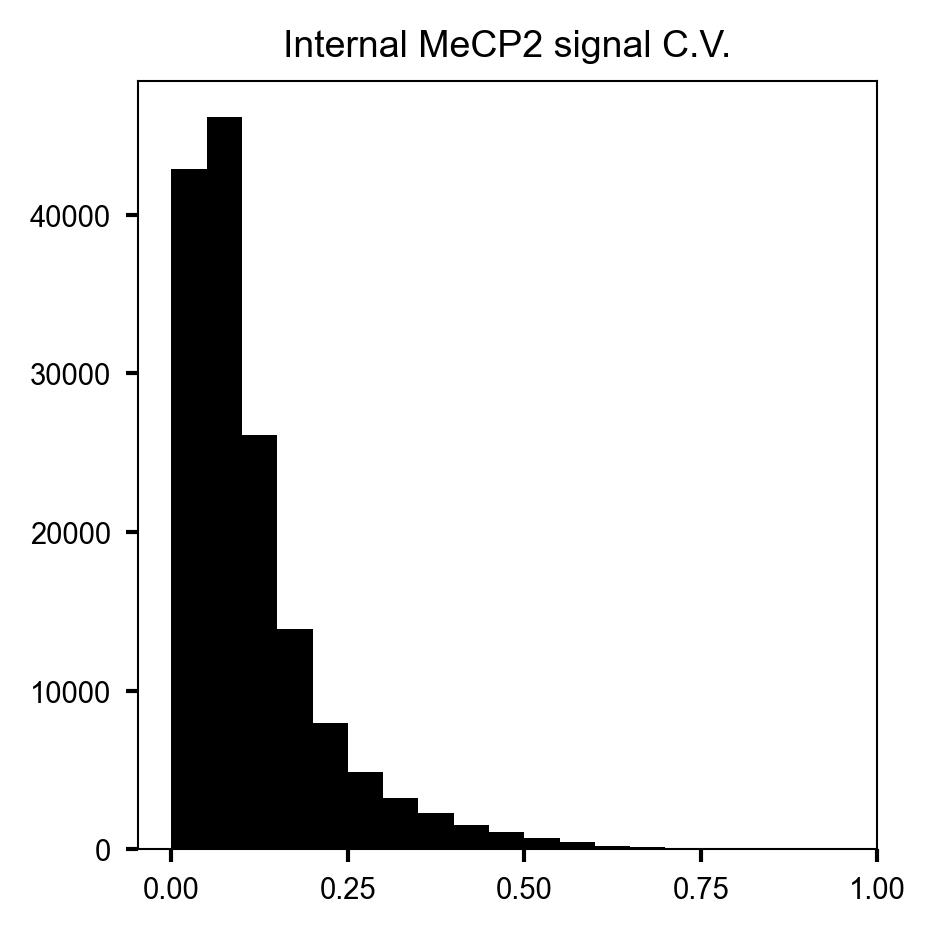

In [8]:
fig = plt.figure(figsize=(3,3), dpi=300)

ax = fig.add_subplot(1,1,1)
ax.hist(df_cell_with_MeCP2['MeCP2_internal_variation'], color='black',  bins=np.arange(0,1,0.05))
ax.set_xticks([0,0.25,0.5,0.75,1.0])
ax.set_title('Internal MeCP2 signal C.V.')
    
plt.show()

# Plot

In [9]:
### calculate Gaussian kernel for density
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    return ax

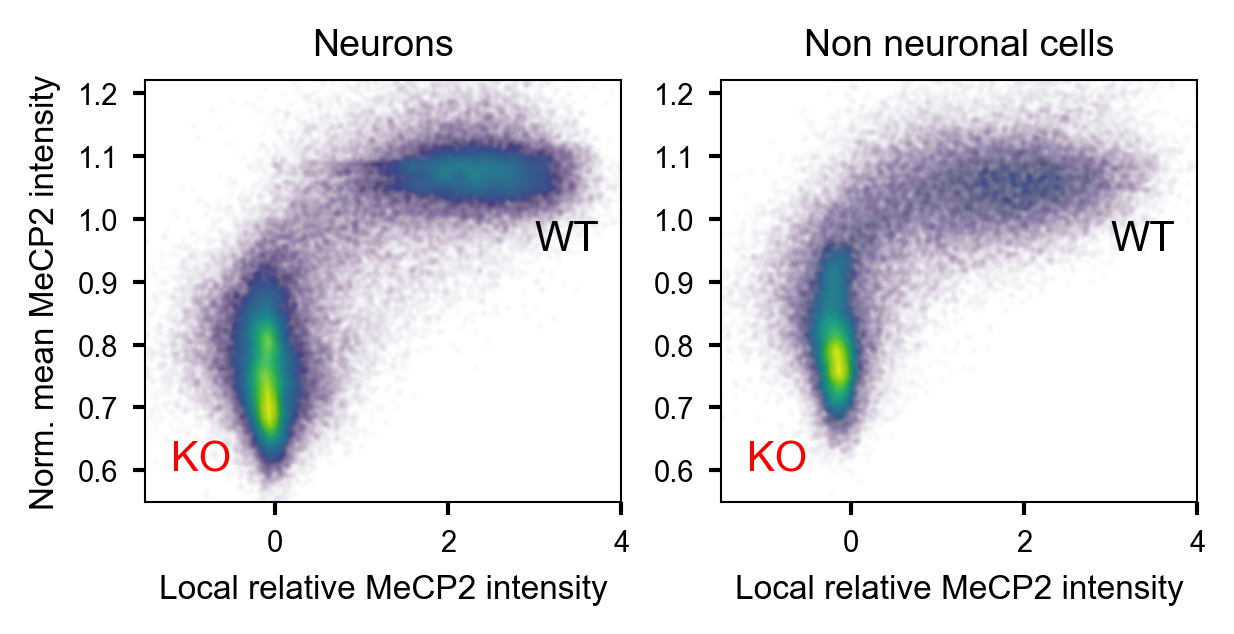

In [10]:
fig = plt.figure(figsize=(4,2), dpi=300)

############ &(df_cell_with_MeCP2.experiment=='0724')
### Neuron
df_plot = df_cell_with_MeCP2[(df_cell_with_MeCP2.cellType=='Neuron')].copy()
ax1 = fig.add_subplot(121)
density_scatter(df_plot['local_MeCP2_signal'].values, df_plot['norm_MeCP2_mean'].values, ax=ax1,
                     bins=[50,50], s=1, alpha=0.01, rasterized=True)
ax1.set_title('Neurons')
ax1.set_xlim(-1.5,4)
ax1.set_ylim(0.55,1.22)
ax1.set_xlabel('Local relative MeCP2 intensity')
ax1.set_ylabel('Norm. mean MeCP2 intensity')

ax1.text(3,0.95,'WT', color='black', fontsize=10)

ax1.text(-1.2, 0.6,'KO', color='red', fontsize=10)

### Non-neuron
df_plot = df_cell_with_MeCP2[(df_cell_with_MeCP2.cellType=='Non-neuron')].copy()
ax2 = fig.add_subplot(122)
density_scatter(df_plot['local_MeCP2_signal'].values, df_plot['norm_MeCP2_mean'].values, ax=ax2,
                     bins=[50,50], s=1, alpha=0.01, rasterized=True)
ax2.set_title('Non neuronal cells')
ax2.set_xlim(-1.5,4)
ax2.set_ylim(0.55,1.22)
ax2.set_xlabel('Local relative MeCP2 intensity')

ax2.text(3,0.95,'WT', color='black', fontsize=10)

ax2.text(-1.2, 0.6,'KO', color='red', fontsize=10)

plt.savefig(os.path.join(figure_folder,'MeCP2_gate_by_cell_types.svg'))
plt.savefig(os.path.join(figure_folder,'MeCP2_gate_by_cell_types.png'))


plt.show()

meta NOT subset; don't know how to subset; dropped


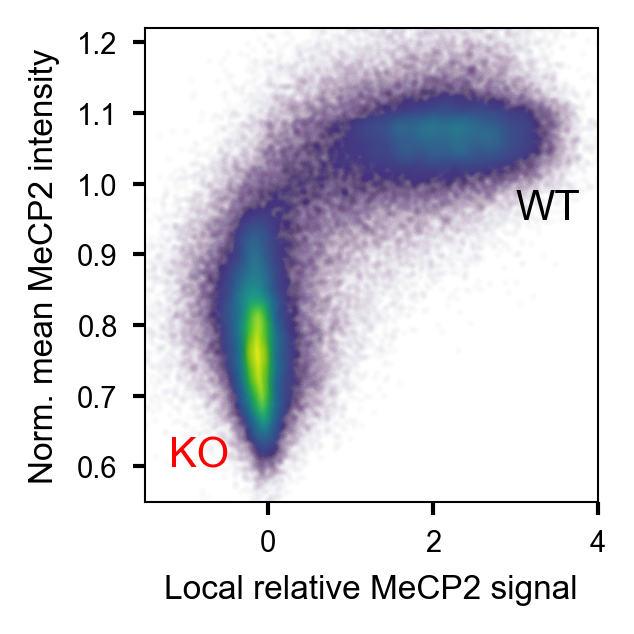

In [12]:
fig = plt.figure(figsize=(2,2), dpi=300)

df_plot = df_cell_with_MeCP2.copy()
ax1 = fig.add_subplot(111)
density_scatter(df_plot['local_MeCP2_signal'].values, df_plot['norm_MeCP2_mean'].values, ax=ax1,
                     bins=[50,50], s=1, alpha=0.01, rasterized=True)
ax1.set_xlim(-1.5,4)
ax1.set_ylim(0.55,1.22)
ax1.set_xlabel('Local relative MeCP2 signal')
ax1.set_ylabel('Norm. mean MeCP2 intensity')

ax1.text(3,0.95,'WT', color='black', fontsize=10)

ax1.text(-1.2, 0.6,'KO', color='red', fontsize=10)

plt.savefig(os.path.join(figure_folder,'MeCP2_gate_all.svg'))
plt.savefig(os.path.join(figure_folder,'MeCP2_gate_all.png'))
plt.savefig(os.path.join(figure_folder,'MeCP2_gate_all.pdf'))

plt.show()

# Define WT versus KO

In [13]:
def get_MeCP2_genotype(row):
    if row['MeCP2_internal_variation']>0.5:
        return 'ND'
    
    # boundaries are defined manually by checking the figures
    if row['cellType']=='Non-neuron':
        if row['norm_MeCP2_mean']<=0.92 and row['local_MeCP2_signal']<=0.2:
            return 'KO'
        if row['norm_MeCP2_mean']>=0.98 and row['local_MeCP2_signal']>=0.5:
            return 'WT'
        return 'ND'
    elif row['cellType']=='Neuron':
        if row['norm_MeCP2_mean']<=0.92 and row['local_MeCP2_signal']<=0.2:
            return 'KO'
        if row['norm_MeCP2_mean']>=0.98 and row['local_MeCP2_signal']>=0.5:
            return 'WT'
        return 'ND'
    
    return 'ND'

In [14]:
df_cell_with_MeCP2['genotype'] = df_cell_with_MeCP2.apply(lambda x: get_MeCP2_genotype(x), axis=1)
df_cell_with_MeCP2

,uid,fov,cellID,DAPI_mean,MeCP2_mean,MeCP2_internal_variation,local_MeCP2_signal,subclass,experiment,norm_MeCP2_mean,cellType,genotype
0,100488189023469889594930787401453076425,0,84,13327.583485,15890.948905,0.052007,1.645142,Oligo,0722,1.162929,Non-neuron,WT
1,112375315532908816646758313607652797643,0,76,9807.039362,2327.309309,0.141345,1.189077,OPC,0722,0.938860,Non-neuron,ND
2,114854375025109577381176113053841629115,0,37,10288.124281,4168.115938,0.243693,-0.474639,Oligo,0722,1.002043,Non-neuron,ND
3,118810555376811432243045980692848875157,0,14,9044.788742,1322.327815,0.031814,-0.338172,Oligo,0722,0.864024,Non-neuron,KO
4,121417342135746412542665712718583471561,0,23,7973.871122,23389.683572,0.020874,2.682859,L6 CT,0722,1.086972,Neuron,WT
...,...,...,...,...,...,...,...,...,...,...,...,...
152263,94651392123118829088321465793420452012,255,35,10421.092444,2552.638264,0.075095,-0.240001,L5 ET,1107,0.776412,Neuron,KO
152264,94750795428183338673959299756273926819,255,40,18821.684732,1455.851107,0.121013,-0.315505,Endo-PVM,1107,0.874692,Non-neuron,KO
152265,9632407225474561357286622891005710050,255,7,17344.687151,31383.434916,0.219786,1.266495,L6 CT,1107,1.046382,Neuron,WT
152266,98298778356884828414810266217154971015,255,73,11635.396624,49907.433544,0.136110,1.757290,L5 ET,1107,1.070655,Neuron,WT


In [15]:
# save the dataframe
df_cell_with_MeCP2.to_csv(r'all_cells_info.csv')

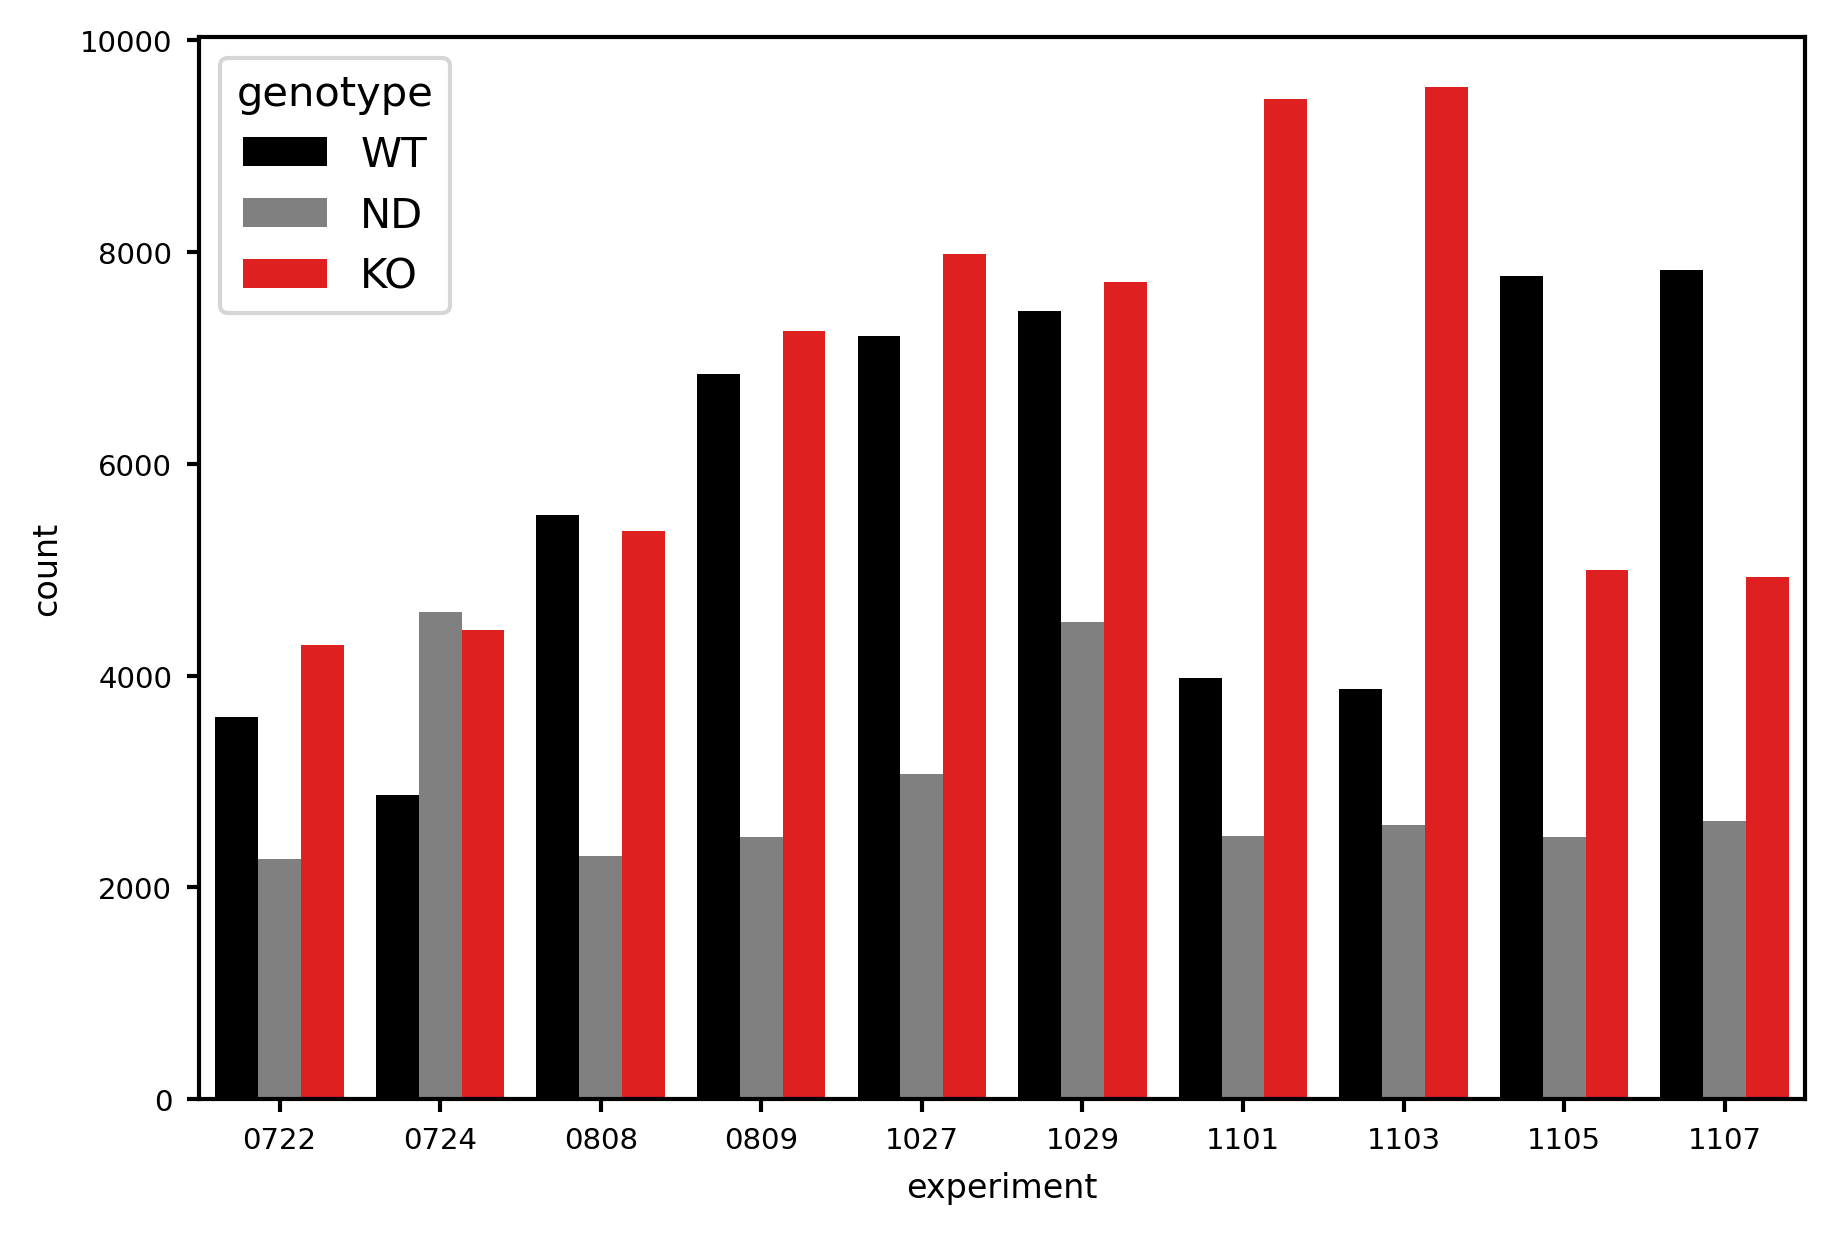

In [16]:
fig = plt.figure(figsize=(6,4), dpi=300)

ax = sns.countplot(data=df_cell_with_MeCP2, x="experiment", hue="genotype", palette={'WT':'black','KO':'red', 'ND':'grey'})

plt.show()